In [1]:
# First we need to import some packages
import keras
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import json
from copy import deepcopy
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.metrics import categorical_accuracy
from keras.wrappers.scikit_learn import KerasClassifier
from keras.metrics import categorical_accuracy

# Now read in the data
data=pd.read_csv('./tmdb_5000_movies.csv')

# Change data and get only what we want
data=deepcopy(data[['title','genres','overview']])

# Print out the first record
print("Data before cleaning: ")
print("Title:", data['title'][0])
print("Genres:", data['genres'][0])
print("Overview:", data['overview'][0], "\n\n")

# define a function to clean our genres from [{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]
# to [Action, Aventure, Fantasy, Science Fiction]
def clean_genres(genre_data):
    # List to hold results
    genre_list = []
    for item in genre_data:
        # Since data is json we can use the json lib
        json_data = json.loads(item)
        temp_list = []

        for dict_item in json_data:
            # Grab only the genre names
            temp_list.append(dict_item["name"])
    
        genre_list.append(temp_list)

    return genre_list

def clean_overview(overview_list):
    # List of words to remove
    words_to_remove = ["a", "and", "the", "but", "nor", "else", "or", "its", "it's", "of", "to", "in", "on", "is", "be",
                       "he", "his", "him", "she", "her", "an", "as", "for", "by", "are", "if", "it",
                       "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t",
                       "u", "v", "w", "x", "y", "z", "there", "their", "they're", "where", "wear", "were", "this", "that"
                      ]

    # List to hold results
    clean_overview_list = []
    for item in overview_list:
        # force item to be treated as a string
        item =str(item)
        
        # Split into a list of words
        words_list = item.split()
        
        temp_list = []
        # Remove any punctuation
        for word in words_list:
            # force item to be treated as a string, but first check if it is not empty
            if word:
                word = str(word)
                word = word.replace(",", "")
                word = word.replace(".", "")
                word = word.replace("\"", "")
                word = word.replace("-", "")
                word = word.replace(")", "")
                word = word.replace("(", "")
                word = word.replace("?", "")
                word = word.replace("!", "")
                word = word.replace("~", "")
                word = word.replace("`", "")
                word = word.replace("'", "")
                word = word.replace("’", "")
                word = word.replace(";", "")
                word = word.replace(":", "")
                word = word.replace("…", "")
                word = word.replace("−", "")
                temp_list.append(word)
        
        words_list = temp_list

        # Create a new list of filtered words
        filtered_words_list = [word for word in words_list if word.lower() not in words_to_remove]
        
        clean_overview_list.append(filtered_words_list)

    return clean_overview_list

data["genres"] = clean_genres(data["genres"])
data["overview"] = clean_overview(data["overview"])

# Print out the first record again
print("Data after cleaning: ")
print("Title:", data['title'][0])
print("Genres:", data['genres'][0])
print("Overview:", data['overview'][0], "\n\n")

Data before cleaning: 
Title: Avatar
Genres: [{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]
Overview: In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization. 


Data after cleaning: 
Title: Avatar
Genres: ['Action', 'Adventure', 'Fantasy', 'Science Fiction']
Overview: ['22nd', 'century', 'paraplegic', 'Marine', 'dispatched', 'moon', 'Pandora', 'unique', 'mission', 'becomes', 'torn', 'between', 'following', 'orders', 'protecting', 'alien', 'civilization'] 




In [2]:
# Next we use the Tokenizer from Keras to make our life easier. It will tokenize the text and encode (vectorize) it.
# But first let's copy our data

data_copy = deepcopy(data)

# Make one for each
overview_tokenizer = Tokenizer()
genre_tokenizer = Tokenizer()

# Feed tokenizers the data
overview_tokenizer.fit_on_texts(data_copy["overview"])
genre_tokenizer.fit_on_texts(data_copy["genres"])

# Show what the tokenizers found.
print("Overview word count:", overview_tokenizer.word_counts, "\n\n")
print("Genre word count:", genre_tokenizer.word_counts, "\n\n")
print("Overview unique word count:", len(overview_tokenizer.word_counts))
print("Genre unique word count:", len(genre_tokenizer.word_counts), "\n\n")

# Show how genre/overview are index
print("Overview index values:", overview_tokenizer.word_index, "\n\n")
print("Genre index values:", genre_tokenizer.word_index, "\n\n")

Overview word count: OrderedDict([('22nd', 4), ('century', 73), ('paraplegic', 1), ('marine', 14), ('dispatched', 9), ('moon', 16), ('pandora', 1), ('unique', 25), ('mission', 151), ('becomes', 263), ('torn', 23), ('between', 221), ('following', 51), ('orders', 20), ('protecting', 13), ('alien', 67), ('civilization', 10), ('captain', 61), ('barbossa', 1), ('long', 81), ('believed', 13), ('dead', 118), ('has', 949), ('come', 146), ('back', 313), ('life', 799), ('headed', 15), ('edge', 9), ('earth', 137), ('with', 2533), ('will', 416), ('turner', 10), ('elizabeth', 25), ('swann', 1), ('nothing', 71), ('quite', 18), ('seems', 91), ('cryptic', 4), ('message', 10), ('from', 1325), ('bonds', 10), ('past', 151), ('sends', 34), ('him', 815), ('trail', 28), ('uncover', 45), ('sinister', 30), ('organization', 34), ('while', 323), ('battles', 15), ('political', 47), ('forces', 124), ('keep', 104), ('secret', 175), ('service', 39), ('alive', 55), ('bond', 72), ('peels', 1), ('layers', 2), ('deceit

In [3]:
# Now we encode the genres and overview to create a matrix
encoded_overview = overview_tokenizer.texts_to_matrix(data_copy["overview"], mode="count")
encoded_genre = genre_tokenizer.texts_to_matrix(data_copy["genres"], mode="count")

print("Encoded overview data set:", encoded_overview, "\n\n")
print("Encoded genre data set:", encoded_genre, "\n\n")
print("Encoded overview data width:", len(encoded_overview[0]))
print("Encoded overview data height:", len(encoded_overview))
print("Encoded genre data width:", len(encoded_genre[0]))
print("Encoded genre data height:", len(encoded_genre), "\n\n")


Encoded overview data set: [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]] 


Encoded genre data set: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 1. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 


Encoded overview data width: 23662
Encoded overview data height: 4803
Encoded genre data width: 21
Encoded genre data height: 4803 




In [4]:
# Our data is now ready :)... I think.
print("Sample Data:", data_copy["title"][0], data_copy["genres"][0], data_copy["overview"][0])
print("Sample Data Encoded:", data_copy["title"][0], encoded_genre[0], encoded_overview[0], "\n\n")

Sample Data: Avatar ['Action', 'Adventure', 'Fantasy', 'Science Fiction'] ['22nd', 'century', 'paraplegic', 'Marine', 'dispatched', 'moon', 'Pandora', 'unique', 'mission', 'becomes', 'torn', 'between', 'following', 'orders', 'protecting', 'alien', 'civilization']
Sample Data Encoded: Avatar [0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.] 




In [5]:
# Now we assign stuff back to our data pandaframe and delete data_copy

# Here we append to and assign to our data pandaframe
data["genres"] = data_copy["genres"]
data["overview"] = data_copy["overview"]
data["title"] = data_copy["title"]
data["one_hot_genre"] = list(encoded_genre)
data["one_hot_overview"] = list(encoded_overview)
data = data.append({"genre_word_index": genre_tokenizer.word_index}, ignore_index=True)
data = data.append({"overview_word_index": overview_tokenizer.word_index}, ignore_index=True)
del data_copy

# Lastly Print our updated data pandaframe
print(data)

                                         title  \
0                                       Avatar   
1     Pirates of the Caribbean: At World's End   
2                                      Spectre   
3                        The Dark Knight Rises   
4                                  John Carter   
...                                        ...   
4800                 Signed, Sealed, Delivered   
4801                          Shanghai Calling   
4802                         My Date with Drew   
4803                                       NaN   
4804                                       NaN   

                                             genres  \
0     [Action, Adventure, Fantasy, Science Fiction]   
1                      [Adventure, Fantasy, Action]   
2                        [Action, Adventure, Crime]   
3                  [Action, Crime, Drama, Thriller]   
4              [Action, Adventure, Science Fiction]   
...                                             ...   
4800          

In [6]:
# Cool, now we can begin to build our nerual network, but first we need x_train, x_test, y_train, y_test
(X_train, X_test, y_train, y_test) = train_test_split(encoded_overview, encoded_genre, test_size=0.20)
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape, "X_test shape:", X_test.shape, "y_test shape:", y_test.shape)

# Make the NN (Modified version from HW2)
def create_NN(hidden_layers = [1000], act = 'relu', opt = 'rmsprop', in_dim=X_train.shape[1], out_dim=y_train.shape[1]): 
    '''create a deep feedforwad neural network using keras
    
    Parameters
    -----------
    hidden_layers: a list that defines the numbers of hidden nodes for all hidden layers, e.g., [1000] indicates
    the nn has only one hidden layer with 1000 nodes, while [1000, 500] defines two hidden layers and the first
    layer has 1000 nodes and the second has 500 nodes.
    act: activation function for all hidden layers
    opt: optimizer
    
    Returns
    -------
    myNN: the neural network model
    
    ''' 
    myNN = keras.models.Sequential()
    
    
    num_hidden_layers = 0
    for layer in hidden_layers:
        num_hidden_layers = num_hidden_layers + 1 
        print("Hidden Layer:", num_hidden_layers, "Size of:", layer)
        #2.1 build all hidden layers
        myNN.add(keras.layers.Dense(
        units=layer,
        input_dim=in_dim,
        activation=act))

    # build the output layer and use sigmoid, https://stackoverflow.com/questions/44164749/how-does-keras-handle-multilabel-classification
    myNN.add(keras.layers.Dense(
    units=out_dim,
    activation='sigmoid'))

    #2.3 choose the optimizer, compile the network and return it. Use 'accuracy' as the metrics
    myNN.compile(optimizer=opt, loss='binary_crossentropy', metrics=[categorical_accuracy])
    return myNN
    
h_nodes = [1000, 500] # two hidden layers with 1000 and 500 nodes, respectively.
myNN = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
myNN.summary()

myNN2 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
myNN3 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
# Note to self and others. This took about ~30 for my machine to complete
history1 = myNN.fit(X_train, y_train, epochs=5, batch_size=2000, verbose=2)
history2 = myNN2.fit(X_train, y_train, epochs=50, batch_size=2000, verbose=2)
history3 = myNN3.fit(X_train, y_train, epochs=500, batch_size=2000, verbose=2)

X_train shape: (3842, 23662) y_train shape: (3842, 21) X_test shape: (961, 23662) y_test shape: (961, 21)
Hidden Layer: 1 Size of: 1000
Hidden Layer: 2 Size of: 500
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              23663000  
_________________________________________________________________
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_2 (Dense)              (None, 21)                10521     
Total params: 24,174,021
Trainable params: 24,174,021
Non-trainable params: 0
_________________________________________________________________
Hidden Layer: 1 Size of: 1000
Hidden Layer: 2 Size of: 500
Hidden Layer: 1 Size of: 1000
Hidden Layer: 2 Size of: 500
Epoch 1/5
2/2 - 4s - loss: 0.6709 - categorical_accuracy: 0.2514
Epoch 2/5
2/2 - 3s - loss:

Epoch 53/500
2/2 - 5s - loss: 0.0022 - categorical_accuracy: 0.7106
Epoch 54/500
2/2 - 5s - loss: 0.0021 - categorical_accuracy: 0.7100
Epoch 55/500
2/2 - 3s - loss: 0.0020 - categorical_accuracy: 0.7082
Epoch 56/500
2/2 - 3s - loss: 0.0019 - categorical_accuracy: 0.7087
Epoch 57/500
2/2 - 3s - loss: 0.0018 - categorical_accuracy: 0.7090
Epoch 58/500
2/2 - 3s - loss: 0.0018 - categorical_accuracy: 0.7067
Epoch 59/500
2/2 - 3s - loss: 0.0017 - categorical_accuracy: 0.7074
Epoch 60/500
2/2 - 3s - loss: 0.0016 - categorical_accuracy: 0.7074
Epoch 61/500
2/2 - 4s - loss: 0.0016 - categorical_accuracy: 0.7085
Epoch 62/500
2/2 - 3s - loss: 0.0015 - categorical_accuracy: 0.7095
Epoch 63/500
2/2 - 3s - loss: 0.0014 - categorical_accuracy: 0.7119
Epoch 64/500
2/2 - 4s - loss: 0.0014 - categorical_accuracy: 0.7129
Epoch 65/500
2/2 - 3s - loss: 0.0013 - categorical_accuracy: 0.7134
Epoch 66/500
2/2 - 4s - loss: 0.0013 - categorical_accuracy: 0.7126
Epoch 67/500
2/2 - 3s - loss: 0.0012 - categoric

2/2 - 4s - loss: 2.5589e-04 - categorical_accuracy: 0.7015
Epoch 168/500
2/2 - 3s - loss: 2.5410e-04 - categorical_accuracy: 0.7012
Epoch 169/500
2/2 - 3s - loss: 2.5198e-04 - categorical_accuracy: 0.7007
Epoch 170/500
2/2 - 3s - loss: 2.5067e-04 - categorical_accuracy: 0.7002
Epoch 171/500
2/2 - 3s - loss: 2.4827e-04 - categorical_accuracy: 0.6991
Epoch 172/500
2/2 - 7s - loss: 2.4665e-04 - categorical_accuracy: 0.6960
Epoch 173/500
2/2 - 3s - loss: 2.4499e-04 - categorical_accuracy: 0.6926
Epoch 174/500
2/2 - 4s - loss: 2.4365e-04 - categorical_accuracy: 0.6895
Epoch 175/500
2/2 - 4s - loss: 2.4132e-04 - categorical_accuracy: 0.6900
Epoch 176/500
2/2 - 3s - loss: 2.3958e-04 - categorical_accuracy: 0.6916
Epoch 177/500
2/2 - 3s - loss: 2.3862e-04 - categorical_accuracy: 0.6955
Epoch 178/500
2/2 - 4s - loss: 2.3647e-04 - categorical_accuracy: 0.6996
Epoch 179/500
2/2 - 3s - loss: 2.3472e-04 - categorical_accuracy: 0.6994
Epoch 180/500
2/2 - 4s - loss: 2.3312e-04 - categorical_accuracy:

Epoch 280/500
2/2 - 3s - loss: 1.4239e-04 - categorical_accuracy: 0.6851
Epoch 281/500
2/2 - 3s - loss: 1.4113e-04 - categorical_accuracy: 0.6884
Epoch 282/500
2/2 - 3s - loss: 1.4064e-04 - categorical_accuracy: 0.6887
Epoch 283/500
2/2 - 3s - loss: 1.4004e-04 - categorical_accuracy: 0.6900
Epoch 284/500
2/2 - 7s - loss: 1.3923e-04 - categorical_accuracy: 0.6890
Epoch 285/500
2/2 - 4s - loss: 1.3934e-04 - categorical_accuracy: 0.6874
Epoch 286/500
2/2 - 4s - loss: 1.3827e-04 - categorical_accuracy: 0.6861
Epoch 287/500
2/2 - 4s - loss: 1.3763e-04 - categorical_accuracy: 0.6825
Epoch 288/500
2/2 - 4s - loss: 1.3746e-04 - categorical_accuracy: 0.6788
Epoch 289/500
2/2 - 3s - loss: 1.3663e-04 - categorical_accuracy: 0.6739
Epoch 290/500
2/2 - 4s - loss: 1.3612e-04 - categorical_accuracy: 0.6741
Epoch 291/500
2/2 - 4s - loss: 1.3632e-04 - categorical_accuracy: 0.6746
Epoch 292/500
2/2 - 4s - loss: 1.3612e-04 - categorical_accuracy: 0.6754
Epoch 293/500
2/2 - 4s - loss: 1.3475e-04 - categor

Epoch 393/500
2/2 - 3s - loss: 9.6929e-05 - categorical_accuracy: 0.6754
Epoch 394/500
2/2 - 3s - loss: 9.7093e-05 - categorical_accuracy: 0.6746
Epoch 395/500
2/2 - 6s - loss: 9.6187e-05 - categorical_accuracy: 0.6749
Epoch 396/500
2/2 - 4s - loss: 9.6263e-05 - categorical_accuracy: 0.6775
Epoch 397/500
2/2 - 4s - loss: 9.6585e-05 - categorical_accuracy: 0.6765
Epoch 398/500
2/2 - 4s - loss: 9.5387e-05 - categorical_accuracy: 0.6749
Epoch 399/500
2/2 - 4s - loss: 9.5298e-05 - categorical_accuracy: 0.6739
Epoch 400/500
2/2 - 3s - loss: 9.5850e-05 - categorical_accuracy: 0.6741
Epoch 401/500
2/2 - 3s - loss: 9.4716e-05 - categorical_accuracy: 0.6749
Epoch 402/500
2/2 - 3s - loss: 9.4417e-05 - categorical_accuracy: 0.6733
Epoch 403/500
2/2 - 4s - loss: 9.4131e-05 - categorical_accuracy: 0.6705
Epoch 404/500
2/2 - 3s - loss: 9.3938e-05 - categorical_accuracy: 0.6692
Epoch 405/500
2/2 - 3s - loss: 9.4640e-05 - categorical_accuracy: 0.6658
Epoch 406/500
2/2 - 3s - loss: 9.3392e-05 - categor

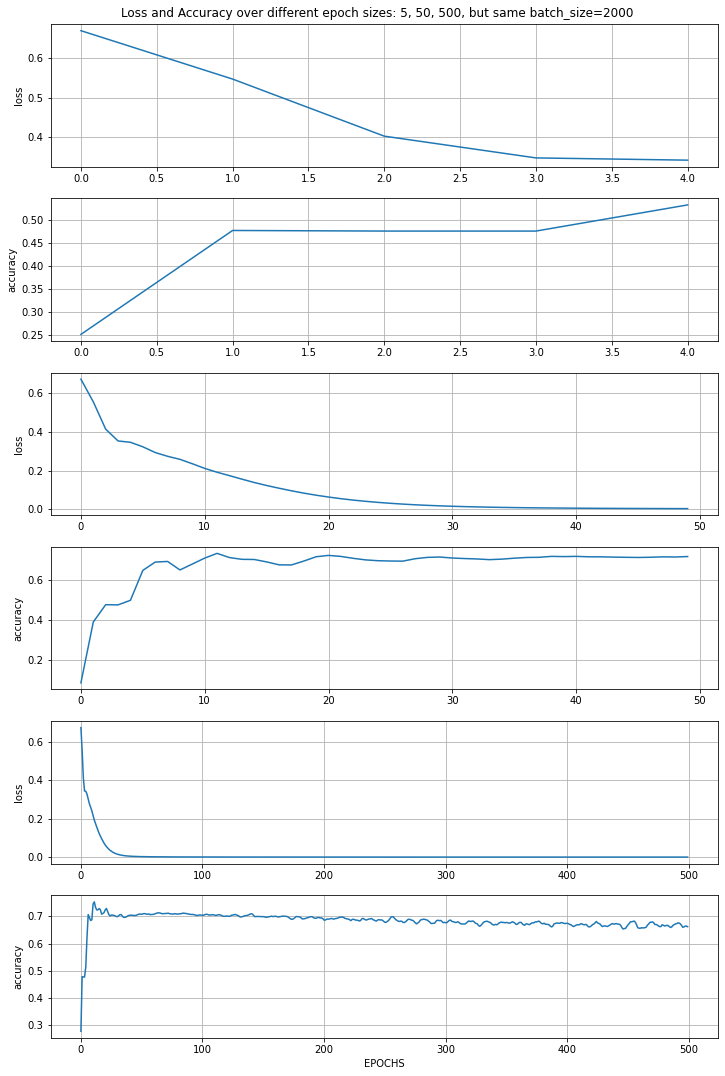

In [7]:
# Lets Plot the history, keys: "loss", "accuracy"
fig1, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6,1)
fig1.suptitle("Loss and Accuracy over different epoch sizes: 5, 50, 500, but same batch_size=2000")
fig1.set_size_inches(10, 15, forward=True)
fig1.tight_layout()

ax1.set_ylabel("loss")
ax1.plot(history1.epoch, history1.history["loss"])
ax1.grid()

ax2.set_ylabel("accuracy")
ax2.plot(history1.epoch, history1.history["categorical_accuracy"])
ax2.grid()

ax3.set_ylabel("loss")
ax3.plot(history2.epoch, history2.history["loss"])
ax3.grid()

ax4.set_ylabel("accuracy")
ax4.plot(history2.epoch, history2.history["categorical_accuracy"])
ax4.grid()

ax5.set_ylabel("loss")
ax5.plot(history3.epoch, history3.history["loss"])
ax5.grid()

ax6.set_xlabel("EPOCHS")
ax6.set_ylabel("accuracy")
ax6.plot(history3.epoch, history3.history["categorical_accuracy"])
ax6.grid()
plt.show()

In [8]:
myNN4 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
history4 = myNN4.fit(X_train, y_train, epochs=15, batch_size=1000, verbose=2)

Hidden Layer: 1 Size of: 1000
Hidden Layer: 2 Size of: 500
Epoch 1/15
4/4 - 4s - loss: 0.6152 - categorical_accuracy: 0.2918
Epoch 2/15
4/4 - 3s - loss: 0.3873 - categorical_accuracy: 0.4763
Epoch 3/15
4/4 - 3s - loss: 0.3429 - categorical_accuracy: 0.5362
Epoch 4/15
4/4 - 3s - loss: 0.2957 - categorical_accuracy: 0.6494
Epoch 5/15
4/4 - 3s - loss: 0.2581 - categorical_accuracy: 0.6385
Epoch 6/15
4/4 - 3s - loss: 0.2199 - categorical_accuracy: 0.7215
Epoch 7/15
4/4 - 3s - loss: 0.1835 - categorical_accuracy: 0.6978
Epoch 8/15
4/4 - 3s - loss: 0.1510 - categorical_accuracy: 0.7046
Epoch 9/15
4/4 - 3s - loss: 0.1216 - categorical_accuracy: 0.6856
Epoch 10/15
4/4 - 3s - loss: 0.0966 - categorical_accuracy: 0.7043
Epoch 11/15
4/4 - 3s - loss: 0.0755 - categorical_accuracy: 0.6965
Epoch 12/15
4/4 - 3s - loss: 0.0580 - categorical_accuracy: 0.7025
Epoch 13/15
4/4 - 3s - loss: 0.0444 - categorical_accuracy: 0.7087
Epoch 14/15
4/4 - 3s - loss: 0.0338 - categorical_accuracy: 0.6918
Epoch 15/15


In [9]:
myNN5 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
history5 = myNN5.fit(X_train, y_train, epochs=15, batch_size=1500, verbose=2)

Hidden Layer: 1 Size of: 1000
Hidden Layer: 2 Size of: 500
Epoch 1/15
3/3 - 5s - loss: 0.6587 - categorical_accuracy: 0.1325
Epoch 2/15
3/3 - 3s - loss: 0.4758 - categorical_accuracy: 0.4352
Epoch 3/15
3/3 - 3s - loss: 0.3465 - categorical_accuracy: 0.4867
Epoch 4/15
3/3 - 3s - loss: 0.3340 - categorical_accuracy: 0.5716
Epoch 5/15
3/3 - 3s - loss: 0.3015 - categorical_accuracy: 0.6156
Epoch 6/15
3/3 - 3s - loss: 0.2682 - categorical_accuracy: 0.6530
Epoch 7/15
3/3 - 3s - loss: 0.2348 - categorical_accuracy: 0.7087
Epoch 8/15
3/3 - 3s - loss: 0.2056 - categorical_accuracy: 0.7426
Epoch 9/15
3/3 - 3s - loss: 0.1766 - categorical_accuracy: 0.7454
Epoch 10/15
3/3 - 3s - loss: 0.1502 - categorical_accuracy: 0.7267
Epoch 11/15
3/3 - 3s - loss: 0.1281 - categorical_accuracy: 0.7231
Epoch 12/15
3/3 - 3s - loss: 0.1065 - categorical_accuracy: 0.7376
Epoch 13/15
3/3 - 3s - loss: 0.0882 - categorical_accuracy: 0.7467
Epoch 14/15
3/3 - 3s - loss: 0.0725 - categorical_accuracy: 0.7371
Epoch 15/15


In [10]:
myNN6 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
history6 = myNN6.fit(X_train, y_train, epochs=15, batch_size=1750, verbose=2)

Hidden Layer: 1 Size of: 1000
Hidden Layer: 2 Size of: 500
Epoch 1/15
3/3 - 5s - loss: 0.6674 - categorical_accuracy: 0.2142
Epoch 2/15
3/3 - 6s - loss: 0.4837 - categorical_accuracy: 0.4953
Epoch 3/15
3/3 - 4s - loss: 0.3521 - categorical_accuracy: 0.4771
Epoch 4/15
3/3 - 3s - loss: 0.3398 - categorical_accuracy: 0.5692
Epoch 5/15
3/3 - 3s - loss: 0.3037 - categorical_accuracy: 0.6749
Epoch 6/15
3/3 - 3s - loss: 0.2727 - categorical_accuracy: 0.6538
Epoch 7/15
3/3 - 3s - loss: 0.2460 - categorical_accuracy: 0.6939
Epoch 8/15
3/3 - 3s - loss: 0.2149 - categorical_accuracy: 0.7093
Epoch 9/15
3/3 - 3s - loss: 0.1860 - categorical_accuracy: 0.6968
Epoch 10/15
3/3 - 3s - loss: 0.1618 - categorical_accuracy: 0.7043
Epoch 11/15
3/3 - 3s - loss: 0.1378 - categorical_accuracy: 0.7207
Epoch 12/15
3/3 - 3s - loss: 0.1163 - categorical_accuracy: 0.7249
Epoch 13/15
3/3 - 3s - loss: 0.0980 - categorical_accuracy: 0.7126
Epoch 14/15
3/3 - 3s - loss: 0.0815 - categorical_accuracy: 0.7194
Epoch 15/15


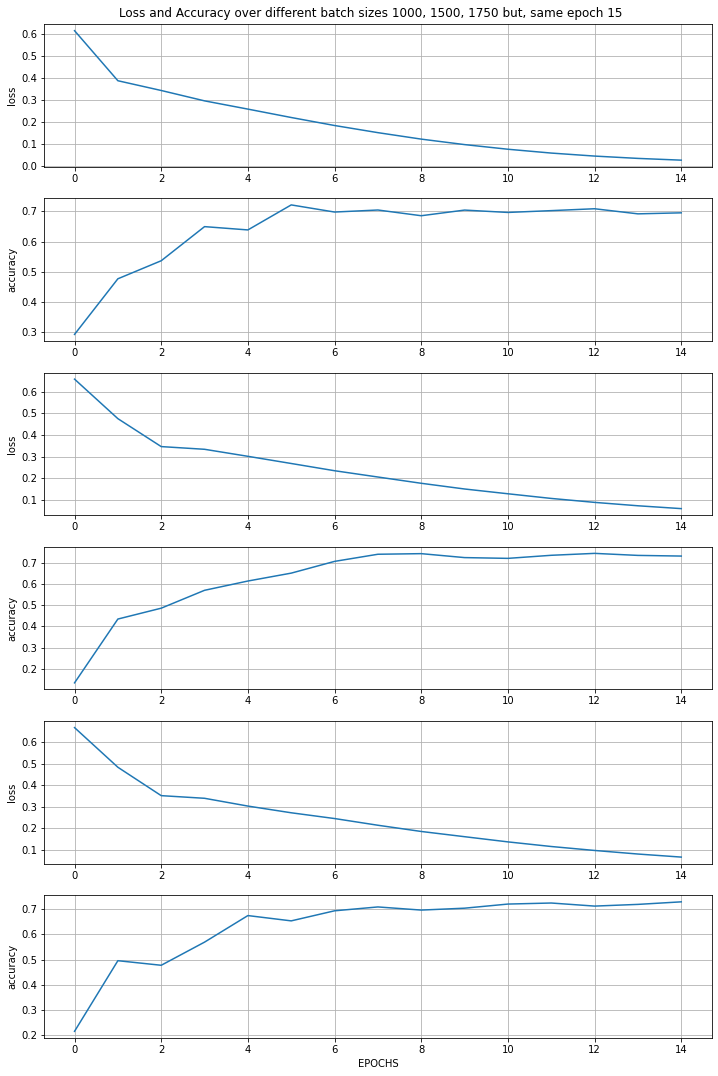

In [11]:
# Lets Plot the history, keys: "loss", "accuracy" again
fig1, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6,1)
fig1.suptitle("Loss and Accuracy over different batch sizes 1000, 1500, 1750 but, same epoch 15")
fig1.set_size_inches(10, 15, forward=True)
fig1.tight_layout()

ax1.set_ylabel("loss")
ax1.plot(history4.epoch, history4.history["loss"])
ax1.grid()

ax2.set_ylabel("accuracy")
ax2.plot(history4.epoch, history4.history["categorical_accuracy"])
ax2.grid()

ax3.set_ylabel("loss")
ax3.plot(history5.epoch, history5.history["loss"])
ax3.grid()

ax4.set_ylabel("accuracy")
ax4.plot(history5.epoch, history5.history["categorical_accuracy"])
ax4.grid()

ax5.set_ylabel("loss")
ax5.plot(history6.epoch, history6.history["loss"])
ax5.grid()

ax6.set_xlabel("EPOCHS")
ax6.set_ylabel("accuracy")
ax6.plot(history6.epoch, history6.history["categorical_accuracy"])
ax6.grid()
plt.show()

In [12]:
myNN7 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
history7 = myNN7.fit(X_train, y_train, epochs=15, batch_size=100, verbose=2)

Hidden Layer: 1 Size of: 1000
Hidden Layer: 2 Size of: 500
Epoch 1/15
39/39 - 7s - loss: 0.3648 - categorical_accuracy: 0.4766
Epoch 2/15
39/39 - 6s - loss: 0.1802 - categorical_accuracy: 0.6312
Epoch 3/15
39/39 - 9s - loss: 0.0690 - categorical_accuracy: 0.6632
Epoch 4/15
39/39 - 5s - loss: 0.0224 - categorical_accuracy: 0.6538
Epoch 5/15
39/39 - 6s - loss: 0.0078 - categorical_accuracy: 0.6434
Epoch 6/15
39/39 - 7s - loss: 0.0035 - categorical_accuracy: 0.6635
Epoch 7/15
39/39 - 6s - loss: 0.0020 - categorical_accuracy: 0.6642
Epoch 8/15
39/39 - 6s - loss: 0.0014 - categorical_accuracy: 0.6635
Epoch 9/15
39/39 - 6s - loss: 0.0010 - categorical_accuracy: 0.6783
Epoch 10/15
39/39 - 5s - loss: 7.9153e-04 - categorical_accuracy: 0.6645
Epoch 11/15
39/39 - 6s - loss: 6.4470e-04 - categorical_accuracy: 0.6853
Epoch 12/15
39/39 - 8s - loss: 5.5167e-04 - categorical_accuracy: 0.6627
Epoch 13/15
39/39 - 8s - loss: 4.9516e-04 - categorical_accuracy: 0.6814
Epoch 14/15
39/39 - 6s - loss: 4.2258

In [13]:
myNN8 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
history8 = myNN8.fit(X_train, y_train, epochs=15, batch_size=250, verbose=2)

Hidden Layer: 1 Size of: 1000
Hidden Layer: 2 Size of: 500
Epoch 1/15
16/16 - 4s - loss: 0.4380 - categorical_accuracy: 0.4581
Epoch 2/15
16/16 - 4s - loss: 0.2737 - categorical_accuracy: 0.5856
Epoch 3/15
16/16 - 4s - loss: 0.1763 - categorical_accuracy: 0.6624
Epoch 4/15
16/16 - 4s - loss: 0.0974 - categorical_accuracy: 0.6848
Epoch 5/15
16/16 - 4s - loss: 0.0484 - categorical_accuracy: 0.6780
Epoch 6/15
16/16 - 4s - loss: 0.0234 - categorical_accuracy: 0.6783
Epoch 7/15
16/16 - 4s - loss: 0.0122 - categorical_accuracy: 0.6760
Epoch 8/15
16/16 - 4s - loss: 0.0069 - categorical_accuracy: 0.6757
Epoch 9/15
16/16 - 4s - loss: 0.0045 - categorical_accuracy: 0.6806
Epoch 10/15
16/16 - 7s - loss: 0.0031 - categorical_accuracy: 0.6934
Epoch 11/15
16/16 - 4s - loss: 0.0024 - categorical_accuracy: 0.6929
Epoch 12/15
16/16 - 4s - loss: 0.0019 - categorical_accuracy: 0.6882
Epoch 13/15
16/16 - 4s - loss: 0.0015 - categorical_accuracy: 0.6853
Epoch 14/15
16/16 - 4s - loss: 0.0013 - categorical_a

In [14]:
myNN9 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
history9 = myNN9.fit(X_train, y_train, epochs=15, batch_size=500, verbose=2)

Hidden Layer: 1 Size of: 1000
Hidden Layer: 2 Size of: 500
Epoch 1/15
8/8 - 4s - loss: 0.5114 - categorical_accuracy: 0.4154
Epoch 2/15
8/8 - 4s - loss: 0.3389 - categorical_accuracy: 0.5419
Epoch 3/15
8/8 - 3s - loss: 0.2672 - categorical_accuracy: 0.6169
Epoch 4/15
8/8 - 3s - loss: 0.2015 - categorical_accuracy: 0.6913
Epoch 5/15
8/8 - 4s - loss: 0.1445 - categorical_accuracy: 0.6877
Epoch 6/15
8/8 - 3s - loss: 0.0973 - categorical_accuracy: 0.6866
Epoch 7/15
8/8 - 4s - loss: 0.0624 - categorical_accuracy: 0.7067
Epoch 8/15
8/8 - 3s - loss: 0.0393 - categorical_accuracy: 0.7041
Epoch 9/15
8/8 - 4s - loss: 0.0248 - categorical_accuracy: 0.6955
Epoch 10/15
8/8 - 6s - loss: 0.0160 - categorical_accuracy: 0.7015
Epoch 11/15
8/8 - 4s - loss: 0.0108 - categorical_accuracy: 0.7012
Epoch 12/15
8/8 - 4s - loss: 0.0076 - categorical_accuracy: 0.7082
Epoch 13/15
8/8 - 3s - loss: 0.0056 - categorical_accuracy: 0.6947
Epoch 14/15
8/8 - 3s - loss: 0.0043 - categorical_accuracy: 0.7082
Epoch 15/15


In [15]:
myNN10 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
history10 = myNN10.fit(X_train, y_train, epochs=15, batch_size=750, verbose=2)

Hidden Layer: 1 Size of: 1000
Hidden Layer: 2 Size of: 500
Epoch 1/15
6/6 - 4s - loss: 0.5831 - categorical_accuracy: 0.3876
Epoch 2/15
6/6 - 3s - loss: 0.3524 - categorical_accuracy: 0.5031
Epoch 3/15
6/6 - 3s - loss: 0.2995 - categorical_accuracy: 0.6046
Epoch 4/15
6/6 - 3s - loss: 0.2475 - categorical_accuracy: 0.6978
Epoch 5/15
6/6 - 3s - loss: 0.1949 - categorical_accuracy: 0.7145
Epoch 6/15
6/6 - 3s - loss: 0.1497 - categorical_accuracy: 0.6681
Epoch 7/15
6/6 - 3s - loss: 0.1113 - categorical_accuracy: 0.6752
Epoch 8/15
6/6 - 3s - loss: 0.0813 - categorical_accuracy: 0.6897
Epoch 9/15
6/6 - 3s - loss: 0.0587 - categorical_accuracy: 0.6923
Epoch 10/15
6/6 - 3s - loss: 0.0422 - categorical_accuracy: 0.6853
Epoch 11/15
6/6 - 4s - loss: 0.0304 - categorical_accuracy: 0.6908
Epoch 12/15
6/6 - 6s - loss: 0.0221 - categorical_accuracy: 0.7150
Epoch 13/15
6/6 - 4s - loss: 0.0163 - categorical_accuracy: 0.7009
Epoch 14/15
6/6 - 3s - loss: 0.0123 - categorical_accuracy: 0.7009
Epoch 15/15


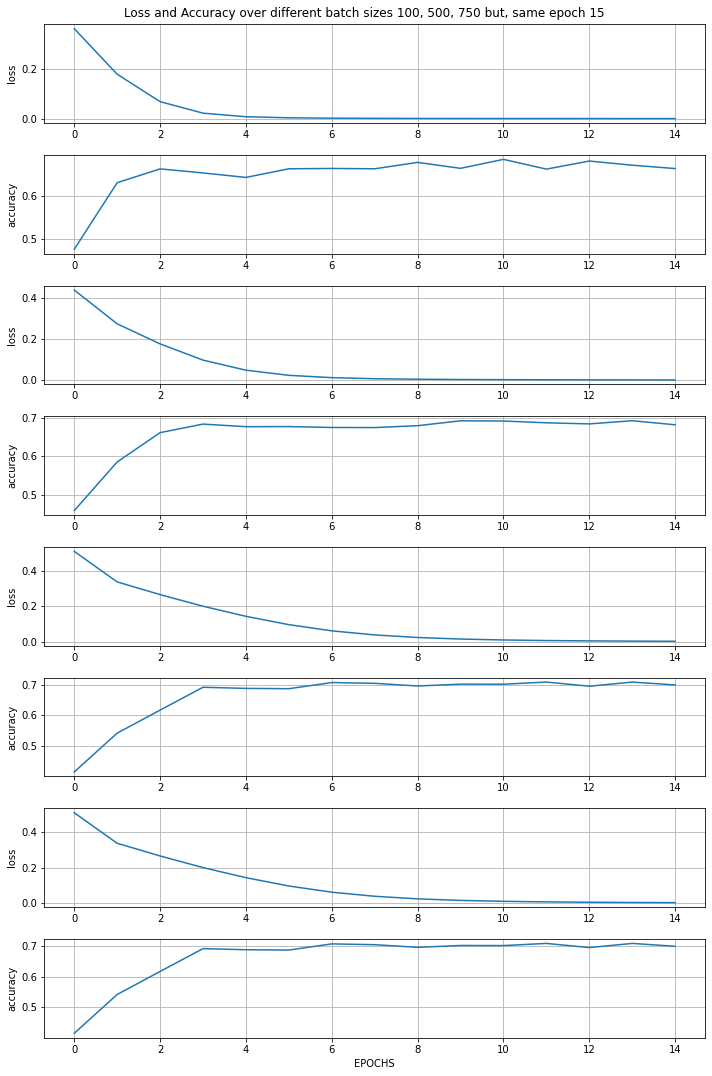

In [16]:
# Lets Plot the history, keys: "loss", "accuracy" again
fig1, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(8,1)
fig1.suptitle("Loss and Accuracy over different batch sizes 100, 500, 750 but, same epoch 15")
fig1.set_size_inches(10, 15, forward=True)
fig1.tight_layout()

ax1.set_ylabel("loss")
ax1.plot(history7.epoch, history7.history["loss"])
ax1.grid()

ax2.set_ylabel("accuracy")
ax2.plot(history7.epoch, history7.history["categorical_accuracy"])
ax2.grid()

ax3.set_ylabel("loss")
ax3.plot(history8.epoch, history8.history["loss"])
ax3.grid()

ax4.set_ylabel("accuracy")
ax4.plot(history8.epoch, history8.history["categorical_accuracy"])
ax4.grid()

ax5.set_ylabel("loss")
ax5.plot(history9.epoch, history9.history["loss"])
ax5.grid()

ax6.set_ylabel("accuracy")
ax6.plot(history9.epoch, history9.history["categorical_accuracy"])
ax6.grid()

ax7.set_ylabel("loss")
ax7.plot(history9.epoch, history9.history["loss"])
ax7.grid()

ax8.set_xlabel("EPOCHS")
ax8.set_ylabel("accuracy")
ax8.plot(history9.epoch, history9.history["categorical_accuracy"])
ax8.grid()
plt.show()

Hidden Layer: 1 Size of: 1000
Hidden Layer: 2 Size of: 500
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 1000)              23663000  
_________________________________________________________________
dense_31 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_32 (Dense)             (None, 21)                10521     
Total params: 24,174,021
Trainable params: 24,174,021
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1/1 - 4s - loss: 0.6898 - categorical_accuracy: 0.1312
Epoch 2/15
1/1 - 3s - loss: 0.6369 - categorical_accuracy: 0.4289
Epoch 3/15
1/1 - 3s - loss: 0.5727 - categorical_accuracy: 0.4898
Epoch 4/15
1/1 - 3s - loss: 0.4948 - categorical_accuracy: 0.4854
Epoch 5/15
1/1 - 3s - loss: 0.4178 - categorical

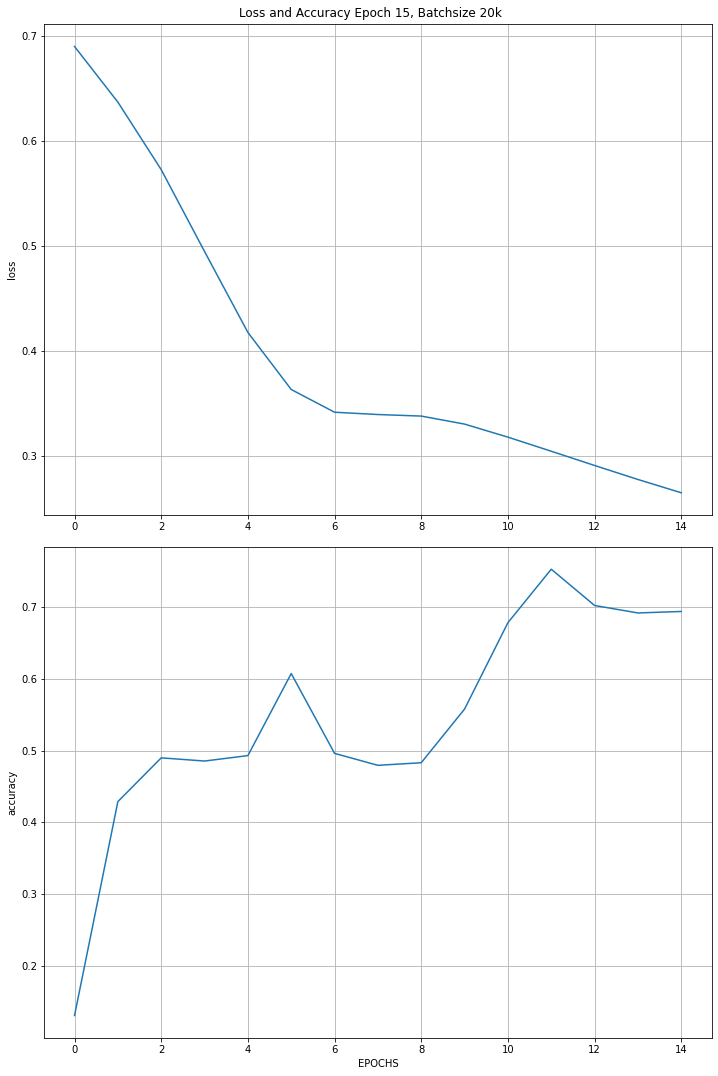

In [17]:
# Before we move on let's try a super large batch size
myNN11 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
myNN11.summary()
history11 = myNN11.fit(X_train, y_train, epochs=15, batch_size=20000, verbose=2)

# Lets Plot the history, keys: "loss", "accuracy" again
fig1, (ax1, ax2) = plt.subplots(2,1)
fig1.suptitle("Loss and Accuracy Epoch 15, Batchsize 20k")
fig1.set_size_inches(10, 15, forward=True)
fig1.tight_layout()

ax1.set_ylabel("loss")
ax1.plot(history11.epoch, history11.history["loss"])
ax1.grid()

ax2.set_xlabel("EPOCHS")
ax2.set_ylabel("accuracy")
ax2.plot(history11.epoch, history11.history["categorical_accuracy"])
ax2.grid()
plt.show()



Hidden Layer: 1 Size of: 1000
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 1000)              23663000  
_________________________________________________________________
dense_34 (Dense)             (None, 21)                21021     
Total params: 23,684,021
Trainable params: 23,684,021
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
2/2 - 3s - loss: 0.6697 - categorical_accuracy: 0.1629
Epoch 2/15
2/2 - 3s - loss: 0.5681 - categorical_accuracy: 0.4977
Epoch 3/15
2/2 - 3s - loss: 0.4689 - categorical_accuracy: 0.4885
Epoch 4/15
2/2 - 3s - loss: 0.3902 - categorical_accuracy: 0.4844
Epoch 5/15
2/2 - 3s - loss: 0.3403 - categorical_accuracy: 0.4865
Epoch 6/15
2/2 - 3s - loss: 0.3116 - categorical_accuracy: 0.5224
Epoch 7/15
2/2 - 3s - loss: 0.2911 - categorical_accuracy: 0.6468
Epoch 8/15


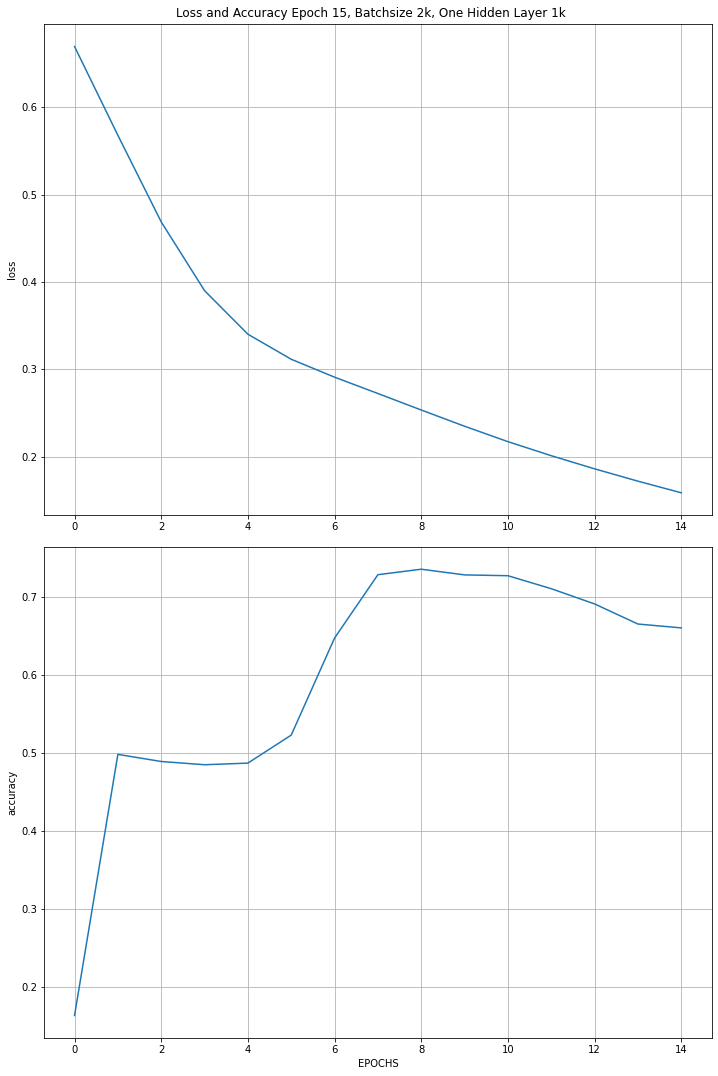

In [18]:
# Okay, by now its clear that batch size and the number of epochs affect accuracy and loss.
# Now let's see how adjusting the hiddel layers and number of nodes affects accuracy and loss.

h_nodes = [1000] # one hidden layers
myNN12 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
myNN12.summary()
history12 = myNN12.fit(X_train, y_train, epochs=15, batch_size=2000, verbose=2)

# Lets Plot the history, keys: "loss", "accuracy" again
fig1, (ax1, ax2) = plt.subplots(2,1)
fig1.suptitle("Loss and Accuracy Epoch 15, Batchsize 2k, One Hidden Layer 1k")
fig1.set_size_inches(10, 15, forward=True)
fig1.tight_layout()

ax1.set_ylabel("loss")
ax1.plot(history12.epoch, history12.history["loss"])
ax1.grid()

ax2.set_xlabel("EPOCHS")
ax2.set_ylabel("accuracy")
ax2.plot(history12.epoch, history12.history["categorical_accuracy"])
ax2.grid()
plt.show()






Hidden Layer: 1 Size of: 100
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 100)               2366300   
_________________________________________________________________
dense_36 (Dense)             (None, 21)                2121      
Total params: 2,368,421
Trainable params: 2,368,421
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
2/2 - 1s - loss: 0.6892 - categorical_accuracy: 0.0560
Epoch 2/15
2/2 - 1s - loss: 0.6622 - categorical_accuracy: 0.1148
Epoch 3/15
2/2 - 1s - loss: 0.6336 - categorical_accuracy: 0.1353
Epoch 4/15
2/2 - 1s - loss: 0.6031 - categorical_accuracy: 0.1348
Epoch 5/15
2/2 - 1s - loss: 0.5714 - categorical_accuracy: 0.1353
Epoch 6/15
2/2 - 1s - loss: 0.5398 - categorical_accuracy: 0.1364
Epoch 7/15
2/2 - 1s - loss: 0.5086 - categorical_accuracy: 0.1390
Epoch 8/15
2/2

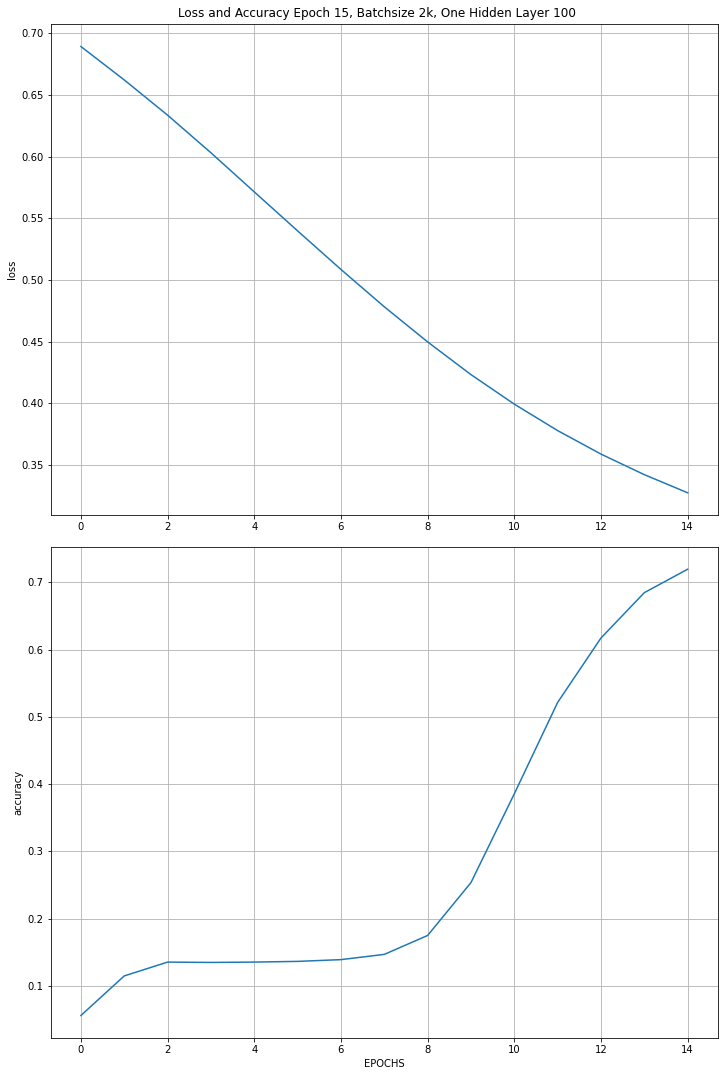

In [19]:
h_nodes = [100] # one hidden layers
myNN13 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
myNN13.summary()
history13 = myNN13.fit(X_train, y_train, epochs=15, batch_size=2000, verbose=2)

# Lets Plot the history, keys: "loss", "accuracy" again
fig1, (ax1, ax2) = plt.subplots(2,1)
fig1.suptitle("Loss and Accuracy Epoch 15, Batchsize 2k, One Hidden Layer 100")
fig1.set_size_inches(10, 15, forward=True)
fig1.tight_layout()

ax1.set_ylabel("loss")
ax1.plot(history13.epoch, history13.history["loss"])
ax1.grid()

ax2.set_xlabel("EPOCHS")
ax2.set_ylabel("accuracy")
ax2.plot(history13.epoch, history13.history["categorical_accuracy"])
ax2.grid()
plt.show()

Hidden Layer: 1 Size of: 10
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 10)                236630    
_________________________________________________________________
dense_38 (Dense)             (None, 21)                231       
Total params: 236,861
Trainable params: 236,861
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
2/2 - 3s - loss: 0.6909 - categorical_accuracy: 0.0297
Epoch 2/15
2/2 - 0s - loss: 0.6859 - categorical_accuracy: 0.0252
Epoch 3/15
2/2 - 0s - loss: 0.6799 - categorical_accuracy: 0.0156
Epoch 4/15
2/2 - 0s - loss: 0.6734 - categorical_accuracy: 0.0091
Epoch 5/15
2/2 - 0s - loss: 0.6666 - categorical_accuracy: 0.0057
Epoch 6/15
2/2 - 0s - loss: 0.6597 - categorical_accuracy: 0.0047
Epoch 7/15
2/2 - 0s - loss: 0.6527 - categorical_accuracy: 0.0039
Epoch 8/15
2/2 - 0s

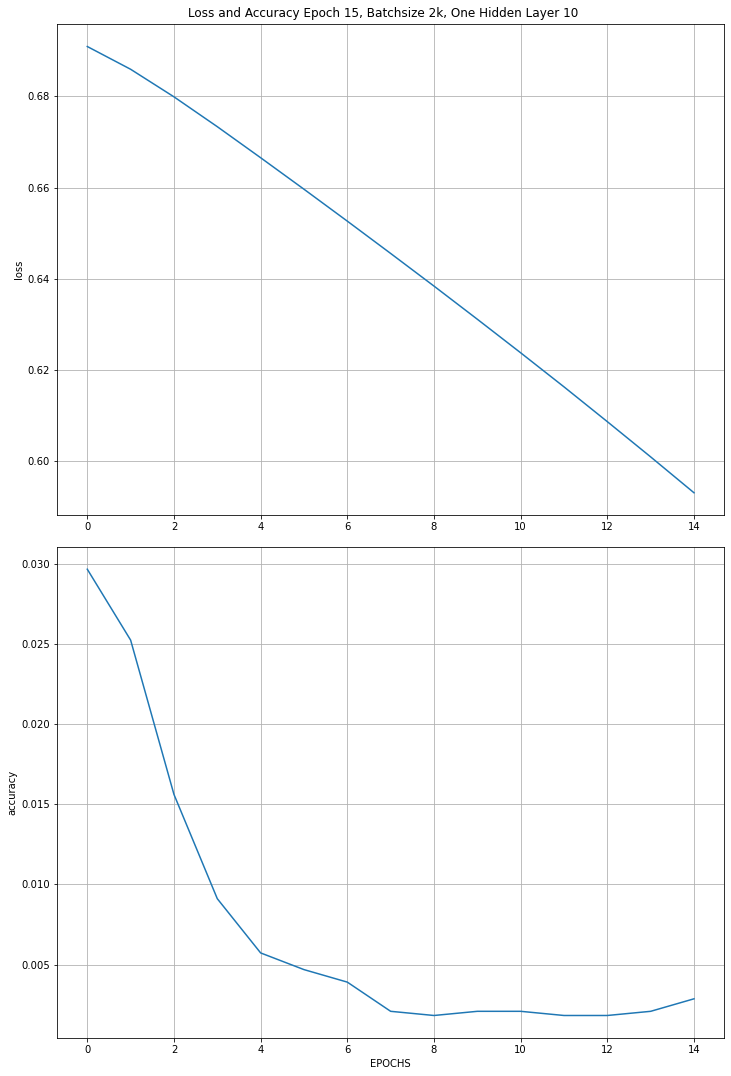

In [20]:
h_nodes = [10] # one hidden layers
myNN14 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
myNN14.summary()
history14 = myNN14.fit(X_train, y_train, epochs=15, batch_size=2000, verbose=2)

# Lets Plot the history, keys: "loss", "accuracy" again
fig1, (ax1, ax2) = plt.subplots(2,1)
fig1.suptitle("Loss and Accuracy Epoch 15, Batchsize 2k, One Hidden Layer 10")
fig1.set_size_inches(10, 15, forward=True)
fig1.tight_layout()

ax1.set_ylabel("loss")
ax1.plot(history14.epoch, history14.history["loss"])
ax1.grid()

ax2.set_xlabel("EPOCHS")
ax2.set_ylabel("accuracy")
ax2.plot(history14.epoch, history14.history["categorical_accuracy"])
ax2.grid()
plt.show()

Hidden Layer: 1 Size of: 1
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 1)                 23663     
_________________________________________________________________
dense_40 (Dense)             (None, 21)                42        
Total params: 23,705
Trainable params: 23,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
2/2 - 1s - loss: 0.6925 - categorical_accuracy: 0.0750
Epoch 2/15
2/2 - 0s - loss: 0.6910 - categorical_accuracy: 0.0687
Epoch 3/15
2/2 - 0s - loss: 0.6893 - categorical_accuracy: 0.0268
Epoch 4/15
2/2 - 0s - loss: 0.6876 - categorical_accuracy: 0.0159
Epoch 5/15
2/2 - 0s - loss: 0.6858 - categorical_accuracy: 0.0146
Epoch 6/15
2/2 - 0s - loss: 0.6841 - categorical_accuracy: 0.0135
Epoch 7/15
2/2 - 0s - loss: 0.6825 - categorical_accuracy: 0.0133
Epoch 8/15
2/2 - 0s - 

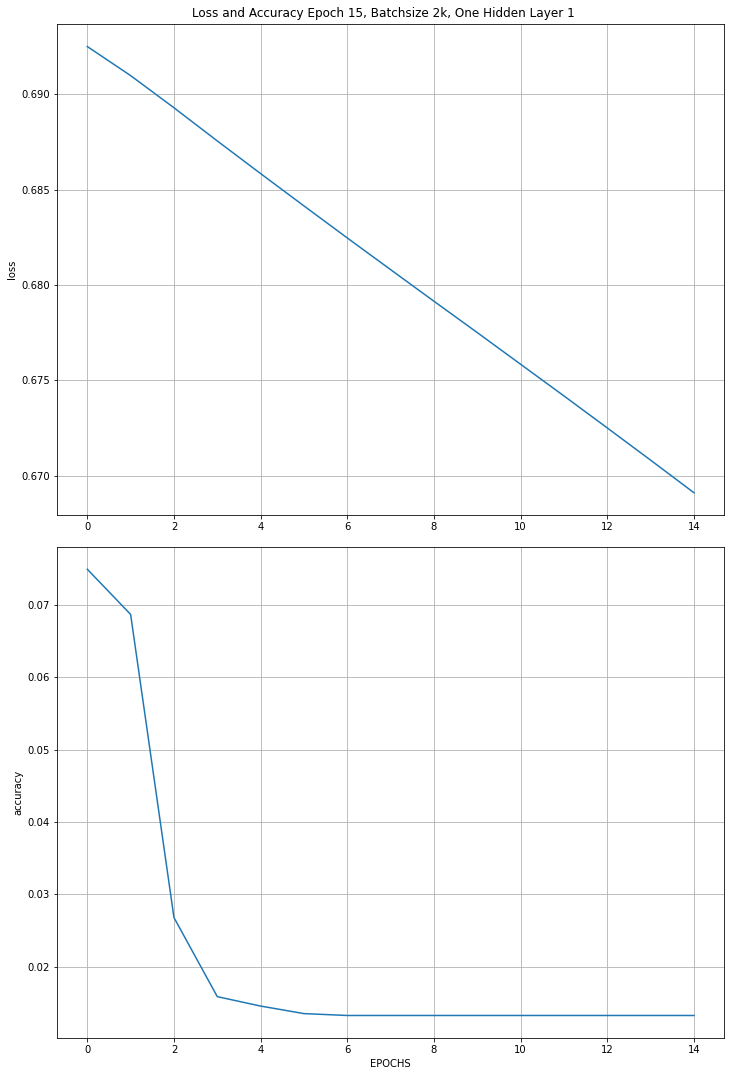

In [21]:
h_nodes = [1] # one hidden layers
myNN15 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
myNN15.summary()
history15 = myNN15.fit(X_train, y_train, epochs=15, batch_size=2000, verbose=2)

# Lets Plot the history, keys: "loss", "accuracy" again
fig1, (ax1, ax2) = plt.subplots(2,1)
fig1.suptitle("Loss and Accuracy Epoch 15, Batchsize 2k, One Hidden Layer 1")
fig1.set_size_inches(10, 15, forward=True)
fig1.tight_layout()

ax1.set_ylabel("loss")
ax1.plot(history15.epoch, history15.history["loss"])
ax1.grid()

ax2.set_xlabel("EPOCHS")
ax2.set_ylabel("accuracy")
ax2.plot(history15.epoch, history15.history["categorical_accuracy"])
ax2.grid()
plt.show()

Hidden Layer: 1 Size of: 10000
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 10000)             236630000 
_________________________________________________________________
dense_42 (Dense)             (None, 21)                210021    
Total params: 236,840,021
Trainable params: 236,840,021
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
2/2 - 32s - loss: 0.6167 - categorical_accuracy: 0.2650
Epoch 2/15
2/2 - 32s - loss: 0.3861 - categorical_accuracy: 0.4766
Epoch 3/15
2/2 - 29s - loss: 0.3231 - categorical_accuracy: 0.5042
Epoch 4/15
2/2 - 33s - loss: 0.2983 - categorical_accuracy: 0.6689
Epoch 5/15
2/2 - 29s - loss: 0.2636 - categorical_accuracy: 0.6999
Epoch 6/15
2/2 - 33s - loss: 0.2286 - categorical_accuracy: 0.6517
Epoch 7/15
2/2 - 29s - loss: 0.1985 - categorical_accuracy: 0.6096
E

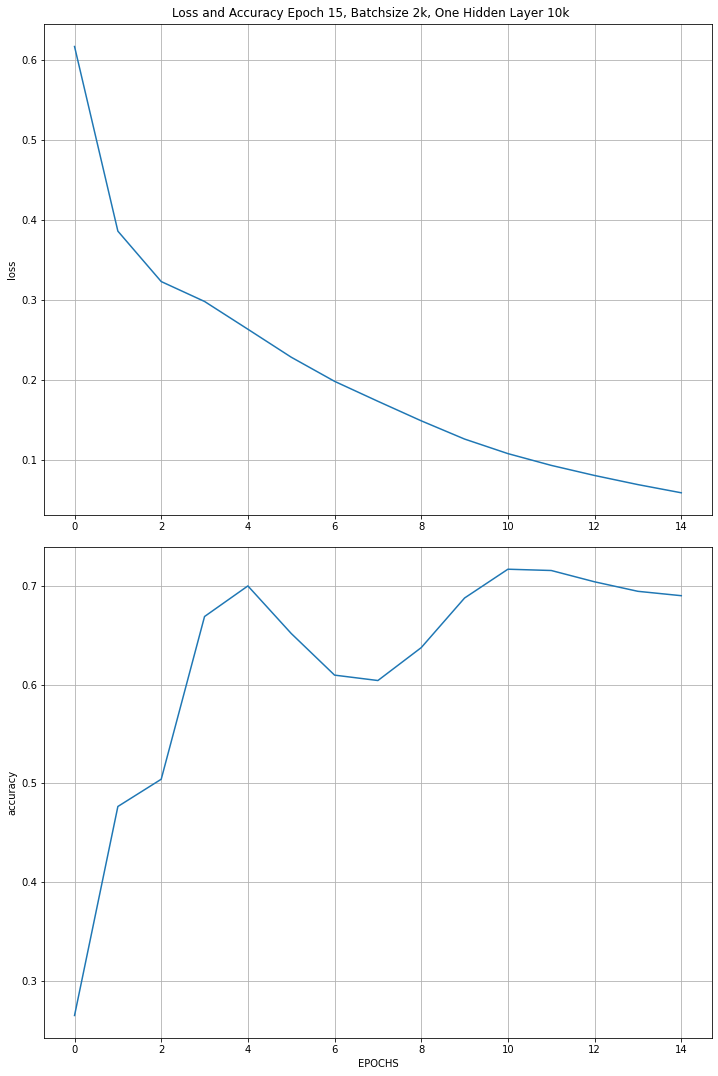

In [22]:
#  Well, what if we increase the the number of nodes using one layer
h_nodes = [10000] # one hidden layers
myNN16 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
myNN16.summary()
history16 = myNN16.fit(X_train, y_train, epochs=15, batch_size=2000, verbose=2)

# Lets Plot the history, keys: "loss", "accuracy" again
fig1, (ax1, ax2) = plt.subplots(2,1)
fig1.suptitle("Loss and Accuracy Epoch 15, Batchsize 2k, One Hidden Layer 10k")
fig1.set_size_inches(10, 15, forward=True)
fig1.tight_layout()

ax1.set_ylabel("loss")
ax1.plot(history16.epoch, history16.history["loss"])
ax1.grid()

ax2.set_xlabel("EPOCHS")
ax2.set_ylabel("accuracy")
ax2.plot(history16.epoch, history16.history["categorical_accuracy"])
ax2.grid()
plt.show()

Hidden Layer: 1 Size of: 5000
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 5000)              118315000 
_________________________________________________________________
dense_44 (Dense)             (None, 21)                105021    
Total params: 118,420,021
Trainable params: 118,420,021
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
2/2 - 17s - loss: 0.6434 - categorical_accuracy: 0.2371
Epoch 2/15
2/2 - 15s - loss: 0.4485 - categorical_accuracy: 0.4969
Epoch 3/15
2/2 - 14s - loss: 0.3441 - categorical_accuracy: 0.4768
Epoch 4/15
2/2 - 18s - loss: 0.3118 - categorical_accuracy: 0.5474
Epoch 5/15
2/2 - 15s - loss: 0.2870 - categorical_accuracy: 0.6976
Epoch 6/15
2/2 - 15s - loss: 0.2565 - categorical_accuracy: 0.7181
Epoch 7/15
2/2 - 15s - loss: 0.2274 - categorical_accuracy: 0.6830
Ep

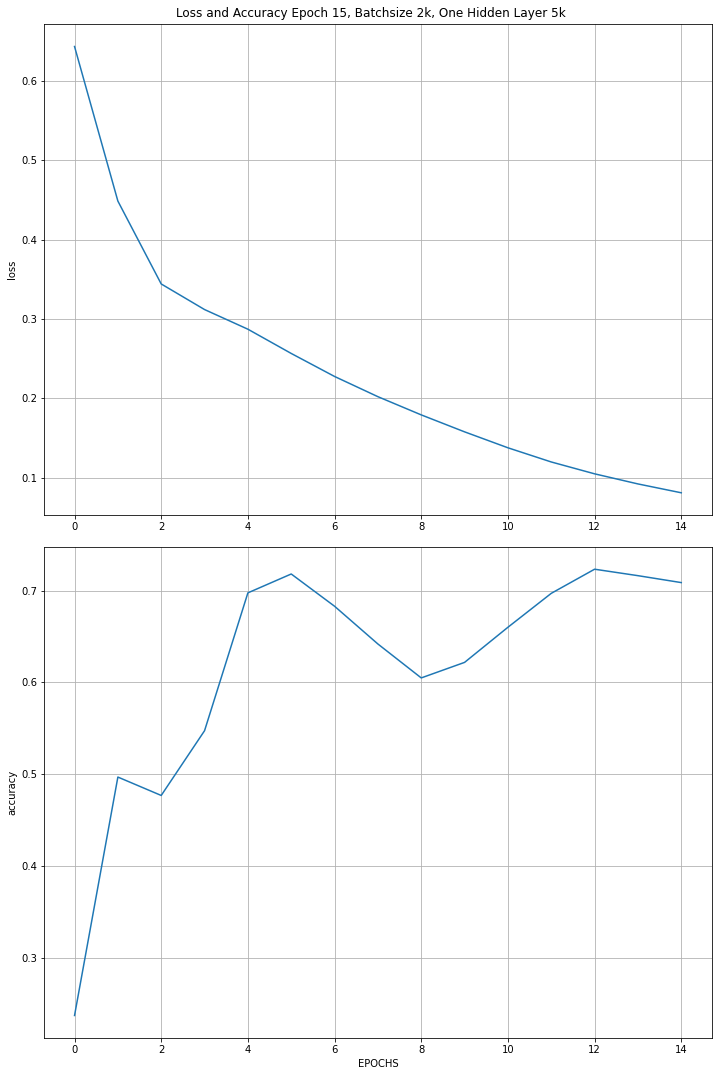

In [23]:
h_nodes = [5000] # one hidden layers
myNN17 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
myNN17.summary()
history17 = myNN17.fit(X_train, y_train, epochs=15, batch_size=2000, verbose=2)

# Lets Plot the history, keys: "loss", "accuracy" again
fig1, (ax1, ax2) = plt.subplots(2,1)
fig1.suptitle("Loss and Accuracy Epoch 15, Batchsize 2k, One Hidden Layer 5k")
fig1.set_size_inches(10, 15, forward=True)
fig1.tight_layout()

ax1.set_ylabel("loss")
ax1.plot(history17.epoch, history17.history["loss"])
ax1.grid()

ax2.set_xlabel("EPOCHS")
ax2.set_ylabel("accuracy")
ax2.plot(history17.epoch, history17.history["categorical_accuracy"])
ax2.grid()
plt.show()

Hidden Layer: 1 Size of: 1000
Hidden Layer: 2 Size of: 1000
Hidden Layer: 3 Size of: 1000
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 1000)              23663000  
_________________________________________________________________
dense_46 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_47 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_48 (Dense)             (None, 21)                21021     
Total params: 25,686,021
Trainable params: 25,686,021
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 - 4s - loss: 0.6631 - categorical_accuracy: 0.4183
Epoch 2/20
2/2 - 3s - loss: 0.4609 - categorical_accuracy: 0.4768
Epoch 3/20
2/2 - 

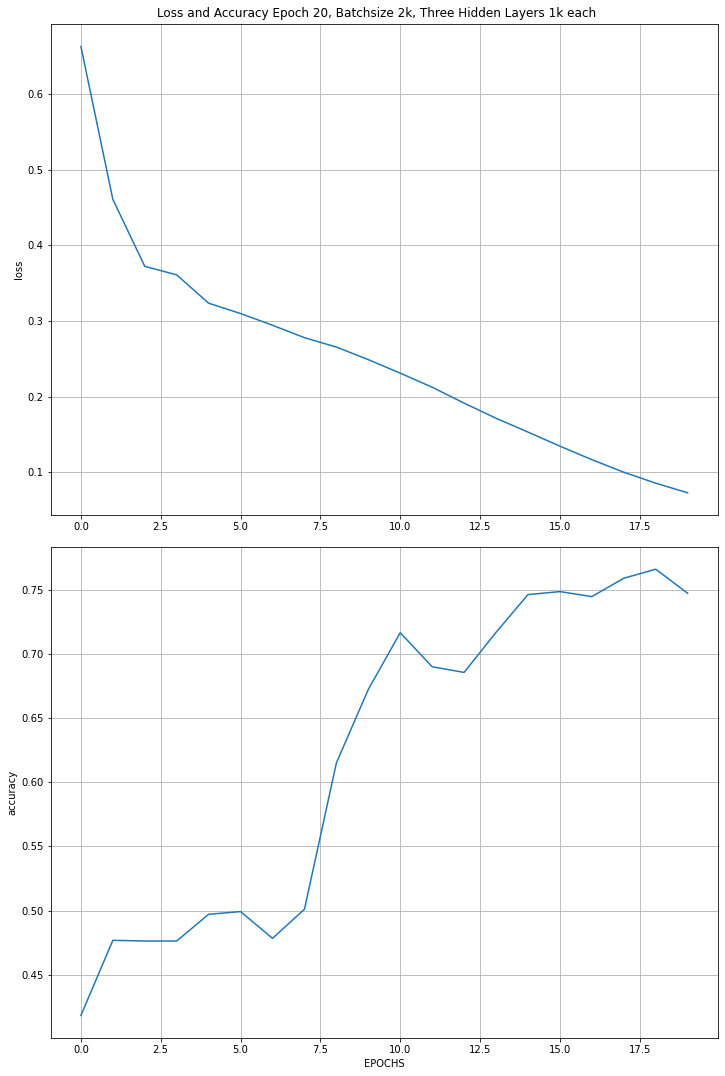

In [24]:
# Okay, now let's try increasing the number of hidden layers.
h_nodes = [1000, 1000, 1000] # three hidden layers
myNN18 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
myNN18.summary()
history18 = myNN18.fit(X_train, y_train, epochs=20, batch_size=2000, verbose=2)

# Lets Plot the history, keys: "loss", "accuracy" again
fig1, (ax1, ax2) = plt.subplots(2,1)
fig1.suptitle("Loss and Accuracy Epoch 20, Batchsize 2k, Three Hidden Layers 1k each")
fig1.set_size_inches(10, 15, forward=True)
fig1.tight_layout()

ax1.set_ylabel("loss")
ax1.plot(history18.epoch, history18.history["loss"])
ax1.grid()

ax2.set_xlabel("EPOCHS")
ax2.set_ylabel("accuracy")
ax2.plot(history18.epoch, history18.history["categorical_accuracy"])
ax2.grid()
plt.show()


Hidden Layer: 1 Size of: 1000
Hidden Layer: 2 Size of: 500
Hidden Layer: 3 Size of: 250
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 1000)              23663000  
_________________________________________________________________
dense_50 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_51 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_52 (Dense)             (None, 21)                5271      
Total params: 24,294,021
Trainable params: 24,294,021
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 - 7s - loss: 0.6755 - categorical_accuracy: 0.0851
Epoch 2/20
2/2 - 4s - loss: 0.5610 - categorical_accuracy: 0.2041
Epoch 3/20
2/2 - 4s

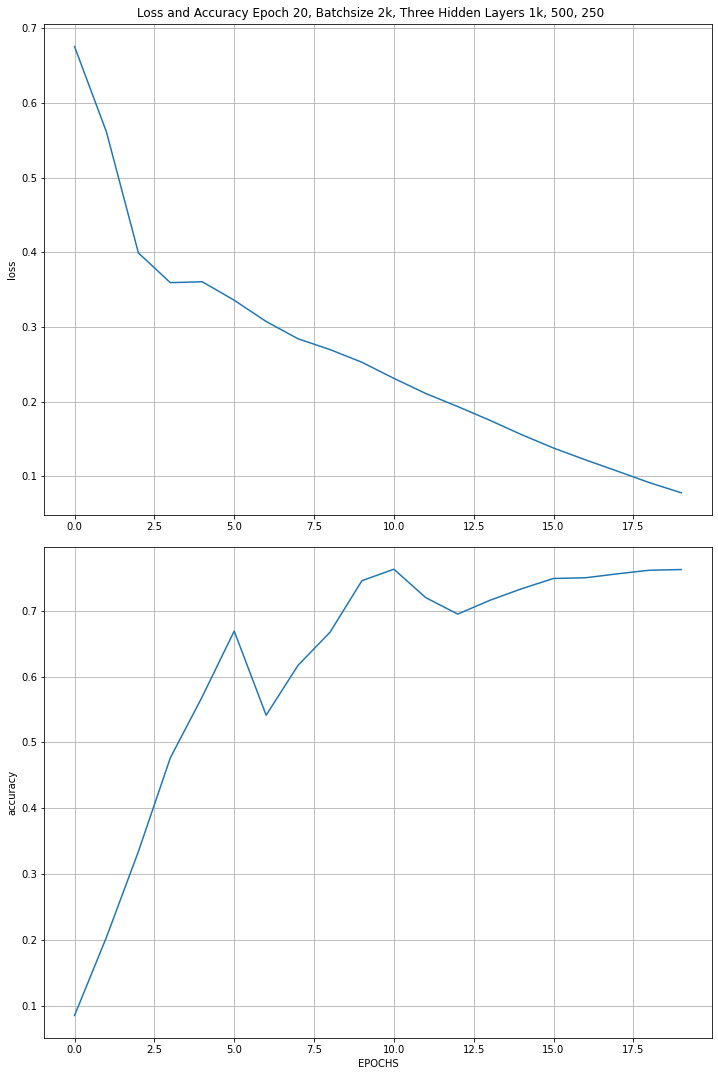

In [25]:
h_nodes = [1000, 500, 250] # three hidden layers
myNN19 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
myNN19.summary()
history19 = myNN19.fit(X_train, y_train, epochs=20, batch_size=2000, verbose=2)

# Lets Plot the history, keys: "loss", "accuracy" again
fig1, (ax1, ax2) = plt.subplots(2,1)
fig1.suptitle("Loss and Accuracy Epoch 20, Batchsize 2k, Three Hidden Layers 1k, 500, 250")
fig1.set_size_inches(10, 15, forward=True)
fig1.tight_layout()

ax1.set_ylabel("loss")
ax1.plot(history19.epoch, history19.history["loss"])
ax1.grid()

ax2.set_xlabel("EPOCHS")
ax2.set_ylabel("accuracy")
ax2.plot(history19.epoch, history19.history["categorical_accuracy"])
ax2.grid()
plt.show()

In [29]:
# Let's see how all these different models prediction results
def myNN_prediction(NN, name, data_to_predict, actual_data):
    '''
        For this function let's use the encoded_overview instead of X_test to evaluate our model.
        Let's just look at our sample Avater movie title.
        It will also calculate percent right and wrong
    '''
    
    print("\nUsing NN model named:", name, ".....")
    results = NN.predict(data_to_predict)
    results[results>=0.5] = 1
    results[results<0.5] = 0
    print("Title: Avater")
    print("Prediction Results:", results[0])
    print("Actual Genre(s)   :", actual_data[0])
    
    # Now we compare the prediction results to the actual encoded_genres
    if len(results) == len(actual_data):
        # All is good
        number_right = 0
        number_wrong = 0
        for index, item in enumerate(results):
            if np.array_equal(item, actual_data[index]):
                # We have a match
                number_right = number_right + 1
            else:
                # We don't have a match
                number_wrong = number_wrong + 1
    
    print("Total Right:", number_right, "Total Wrong:", number_wrong)
    percent_right = (number_right / len(results)) * 100
    percent_wrong = (number_wrong / len(results)) * 100
    print("Percent Right:", percent_right, "Percent Wrong:", percent_wrong, "\n")
    

myNN_prediction(myNN, "myNN", encoded_overview, encoded_genre)
myNN_prediction(myNN2, "myNN2", encoded_overview, encoded_genre)
myNN_prediction(myNN3, "myNN3", encoded_overview, encoded_genre)
myNN_prediction(myNN4, "myNN4", encoded_overview, encoded_genre)
myNN_prediction(myNN5, "myNN5", encoded_overview, encoded_genre)
myNN_prediction(myNN6, "myNN6", encoded_overview, encoded_genre)
myNN_prediction(myNN7, "myNN7", encoded_overview, encoded_genre)
myNN_prediction(myNN8, "myNN8", encoded_overview, encoded_genre)
myNN_prediction(myNN9, "myNN9", encoded_overview, encoded_genre)
myNN_prediction(myNN10, "myNN10", encoded_overview, encoded_genre)
myNN_prediction(myNN11, "myNN11", encoded_overview, encoded_genre)
myNN_prediction(myNN12, "myNN12", encoded_overview, encoded_genre)
myNN_prediction(myNN13, "myNN13", encoded_overview, encoded_genre)
myNN_prediction(myNN14, "myNN14", encoded_overview, encoded_genre)
myNN_prediction(myNN15, "myNN15", encoded_overview, encoded_genre)
myNN_prediction(myNN16, "myNN16", encoded_overview, encoded_genre)
myNN_prediction(myNN17, "myNN17", encoded_overview, encoded_genre)
myNN_prediction(myNN18, "myNN18", encoded_overview, encoded_genre)
myNN_prediction(myNN19, "myNN19", encoded_overview, encoded_genre)





Using NN model named: myNN .....
Title: Avater
Prediction Results: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Actual Genre(s)   : [0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Total Right: 656 Total Wrong: 4147
Percent Right: 13.658130335207161 Percent Wrong: 86.34186966479284 


Using NN model named: myNN2 .....
Title: Avater
Prediction Results: [0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Actual Genre(s)   : [0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Total Right: 3963 Total Wrong: 840
Percent Right: 82.51093066833229 Percent Wrong: 17.489069331667707 


Using NN model named: myNN3 .....
Title: Avater
Prediction Results: [0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Actual Genre(s)   : [0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Total Right: 3964 Total Wrong: 839
Percent Right: 82.53175098896523 Percent Wrong: 17.46824901103477 


Using NN model named: myNN4 ....

In [49]:
# Make the best NN using the best parameters
h_nodes = [1000, 500] # two hidden layers
myBESTNN = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
myBESTNN.summary()
historyBESTNN = myBESTNN.fit(X_train, y_train, epochs=25, batch_size=750, verbose=2)
myNN_prediction(myBESTNN, "myBESTNN", encoded_overview, encoded_genre)

Hidden Layer: 1 Size of: 1000
Hidden Layer: 2 Size of: 500
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_111 (Dense)            (None, 1000)              23663000  
_________________________________________________________________
dense_112 (Dense)            (None, 500)               500500    
_________________________________________________________________
dense_113 (Dense)            (None, 21)                10521     
Total params: 24,174,021
Trainable params: 24,174,021
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
6/6 - 4s - loss: 0.5653 - categorical_accuracy: 0.3006
Epoch 2/25
6/6 - 6s - loss: 0.3495 - categorical_accuracy: 0.5026
Epoch 3/25
6/6 - 3s - loss: 0.2993 - categorical_accuracy: 0.5841
Epoch 4/25
6/6 - 3s - loss: 0.2472 - categorical_accuracy: 0.6728
Epoch 5/25
6/6 - 3s - loss: 0.1973 - categorical

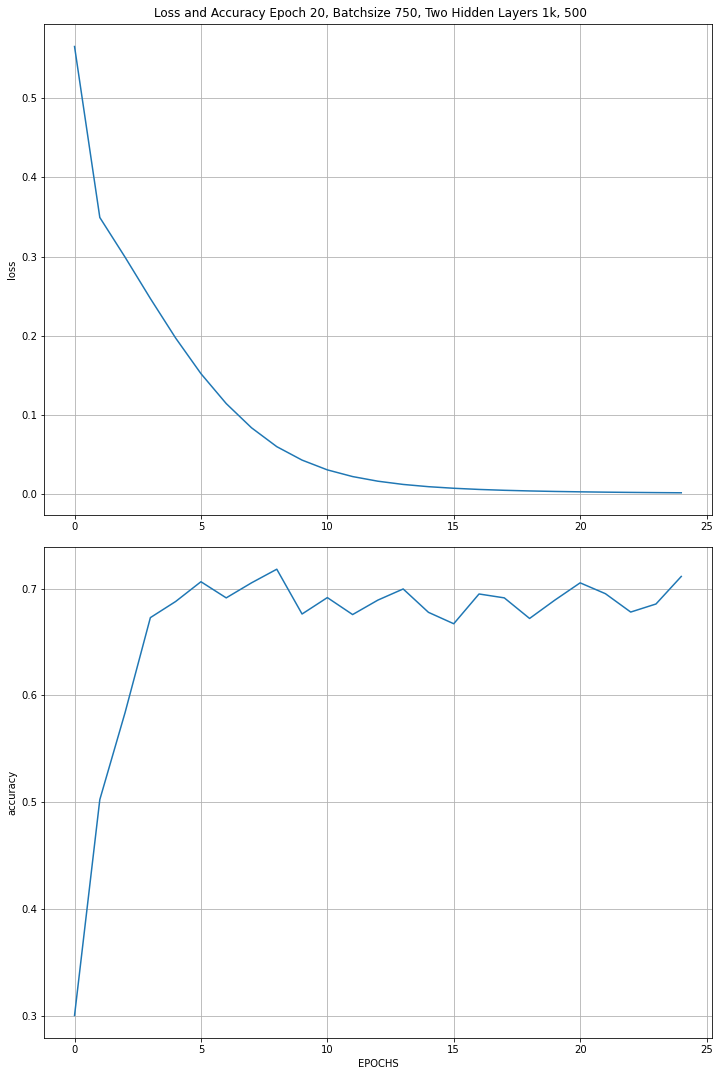

In [50]:
# Lets Plot the history, keys: "loss", "accuracy" again
fig1, (ax1, ax2) = plt.subplots(2,1)
fig1.suptitle("Loss and Accuracy Epoch 20, Batchsize 750, Two Hidden Layers 1k, 500")
fig1.set_size_inches(10, 15, forward=True)
fig1.tight_layout()

ax1.set_ylabel("loss")
ax1.plot(historyBESTNN.epoch, historyBESTNN.history["loss"])
ax1.grid()

ax2.set_xlabel("EPOCHS")
ax2.set_ylabel("accuracy")
ax2.plot(historyBESTNN.epoch, historyBESTNN.history["categorical_accuracy"])
ax2.grid()
plt.show()